### Installs and imports

In [2]:
import os
import re
from typing import List

import camelot
import cv2
import pandas as pd
from PIL import Image

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [12]:
import re
import os


def extract_number(path):
    filename = path.split('/')[-1]  # Get the filename part
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', filename)]

text_paths = [
				f"data/pdf1/cropped_images/{path}"
				for path in os.listdir('data/pdf1/cropped_images')
				if not path.endswith("_Table.png")
		]

sorted(text_paths, key=extract_number)

['data/pdf1/cropped_images/2-3_Title.png',
 'data/pdf1/cropped_images/2-4_Text.png',
 'data/pdf1/cropped_images/2-5_Text.png',
 'data/pdf1/cropped_images/2-6_Text.png',
 'data/pdf1/cropped_images/2-7_Text.png',
 'data/pdf1/cropped_images/2-8_Text.png',
 'data/pdf1/cropped_images/2-9_Section-header.png',
 'data/pdf1/cropped_images/2-10_Text.png',
 'data/pdf1/cropped_images/2-11_Text.png',
 'data/pdf1/cropped_images/2-12_Text.png',
 'data/pdf1/cropped_images/2-13_Text.png',
 'data/pdf1/cropped_images/2-14_Text.png',
 'data/pdf1/cropped_images/3-3_Text.png',
 'data/pdf1/cropped_images/3-4_Text.png',
 'data/pdf1/cropped_images/3-5_Text.png',
 'data/pdf1/cropped_images/3-6_Text.png',
 'data/pdf1/cropped_images/3-7_Section-header.png',
 'data/pdf1/cropped_images/3-8_Text.png',
 'data/pdf1/cropped_images/3-9_Text.png',
 'data/pdf1/cropped_images/3-10_Text.png',
 'data/pdf1/cropped_images/3-11_Text.png',
 'data/pdf1/cropped_images/3-12_Text.png',
 'data/pdf1/cropped_images/3-13_Text.png',
 'da

### Initialize OCR models

In [3]:
from surya.input.load import load_pdf

def pdf_to_png(path: str):
	output_dir = 'original_images'

	if not os.path.exists(output_dir):
		os.makedirs(output_dir)
	
	imgs, _ = load_pdf(path, start_page=1)
	_ = [img.save(f'{output_dir}/{idx}.png') for idx, img in enumerate(imgs, 2)]

In [4]:
from surya.ocr import run_ocr
from surya.model.detection import segformer
from surya.model.recognition.model import load_model
from surya.model.recognition.processor import load_processor
from surya.input.load import load_pdf

det_processor, det_model = segformer.load_processor(), segformer.load_model()
rec_model, rec_processor = load_model(), load_processor()

def run_surya(imgs: List):
  images = [Image.open(path) for path in paths]
  langs = [["ar"]] * len(images)

  return run_ocr(images, langs, det_model, det_processor, rec_model, rec_processor)

Loading detection model vikp/surya_det2 on device cuda with dtype torch.float16
Loading recognition model vikp/surya_rec on device cuda with dtype torch.float16


### Clean tables

In [5]:
headers = ["التفير %", "العام المالي 2021", "العام المالي 2022", "مليون ريال سعودي"]

In [6]:
def is_number(substring):
  cleaned_substring = re.sub(r"\s*\.?\s*", "", substring)
  try:
    cleaned_substring = cleaned_substring.strip("()")
    cleaned_substring = cleaned_substring.replace(",", "")
    float(cleaned_substring.replace("%", ""))
    return True
  except ValueError:
    return False

In [7]:
def clean_text(df: pd.DataFrame, slice=False):
  if not slice:
    df.iloc[:, 3] =  df.iloc[:, 3].str.replace('\n', '')
  else:
    df['التفير %'] = df['التفير %'].str[:-2]

  return df

### Layout analysis

In [5]:
pdf_to_png('data/pdf1/Press Release - 2022 Results (Stock Market).pdf')

In [6]:
from PIL import Image
from surya.detection import batch_text_detection
from surya.layout import batch_layout_detection
from surya.model.detection.segformer import load_model, load_processor
from surya.settings import settings

paths = sorted([f'original_images/{path}' for path in os.listdir('original_images')])
images = [Image.open(path) for path in paths]
model = load_model(checkpoint=settings.LAYOUT_MODEL_CHECKPOINT)
processor = load_processor(checkpoint=settings.LAYOUT_MODEL_CHECKPOINT)
det_model = load_model()
det_processor = load_processor()

line_predictions = batch_text_detection(images, det_model, det_processor)
layout_predictions = batch_layout_detection(images, model, processor, line_predictions)

Loading detection model vikp/surya_layout2 on device cuda with dtype torch.float16
Loading detection model vikp/surya_det2 on device cuda with dtype torch.float16


Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

image = cv2.imread('original_images/2.png')

def draw_bbox(image, bbox, label, color):
    x1, y1, x2, y2 = bbox
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
    cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

label_colors = {
    'Page-footer': (0, 0, 255),
    'Page-header': (0, 255, 0),
    'Figure': (255, 0, 0),
    'Section-header': (255, 255, 0),
    'Text': (0, 255, 255),
    'Title': (255, 0, 255)
}

for bbox in layout_predictions[0].bboxes:
    label = bbox.label
    color = label_colors.get(label, (0, 0, 0))
    draw_bbox(image, bbox.bbox, label, color)

# cv2.imshow('image', image)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

### Reading order

In [15]:
from PIL import Image
from surya.ordering import batch_ordering
from surya.model.ordering.processor import load_processor
from surya.model.ordering.model import load_model

image = Image.open('original_images/2.png')
# bboxes should be a list of lists with layout bboxes for the image in [x1,y1,x2,y2] format
# You can get this from the layout model, see above for usage
bboxes = [bbox.bbox for bbox in layout_predictions[0].bboxes]

model = load_model()
processor = load_processor()

# order_predictions will be a list of dicts, one per image
order_predictions = batch_ordering([image], [bboxes], model, processor)

Loading reading order model vikp/surya_order on device cuda with dtype torch.float16


Finding reading order: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


In [ ]:
ll = [(bbox_1.position, bbox_2.label, bbox_2.bbox) for bbox_1, bbox_2 in zip(order_predictions[0].bboxes, layout_predictions[0].bboxes)]
sorted_list = sorted(ll, key=lambda x: x[0])
sorted_list

In [30]:
from surya.ordering import batch_ordering
from surya.model.ordering.processor import load_processor
from surya.model.ordering.model import load_model

model = load_model()
processor = load_processor()
pages_blocks = []

for page_num in range(len(layout_predictions)):
	image = Image.open(f'original_images/{page_num+2}.png')
	bboxes = [bbox.bbox for bbox in layout_predictions[page_num].bboxes]
	order_predictions = batch_ordering([image], [bboxes], model, processor)
	
	ll = [(bbox_1.position, bbox_2.label, bbox_2.bbox) for bbox_1, bbox_2 in zip(order_predictions[0].bboxes, layout_predictions[page_num].bboxes)]
	sorted_list = sorted(ll, key=lambda x: x[0])
	pages_blocks.append(sorted_list)

Loading reading order model vikp/surya_order on device cuda with dtype torch.float16


Finding reading order: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


In [36]:
paths = sorted([f'original_images/{path}' for path in os.listdir('original_images')])
images = [cv2.imread(path) for path in paths]
output_dir = 'cropped_images'
table_locations = []
figure_locations = []

if not os.path.exists(output_dir):
		os.makedirs(output_dir)

def crop_and_save(image, bbox, label, page_num, bbox_num):
		x1, y1, x2, y2 = bbox
		if y2-y1 > 10 and x2-x1 > 10:
			cropped_image = image[y1:y2, x1:x2]
			filename = f"{page_num}-{bbox_num}_{label}.png"
			cv2.imwrite(os.path.join(output_dir, filename), cropped_image)

for page_num, page in enumerate(pages_blocks):
	for block_id in page:
		pos = block_id[0]
		label = block_id[1]
		bbox = block_id[2]
		if label in ['Text', 'Title', 'Section-header']:
			crop_and_save(images[page_num], bbox, label, page_num+2, pos)
		elif label == 'Table':
			table_locations.append(page_num+2)
			crop_and_save(images[page_num], bbox, label, page_num+2, pos)

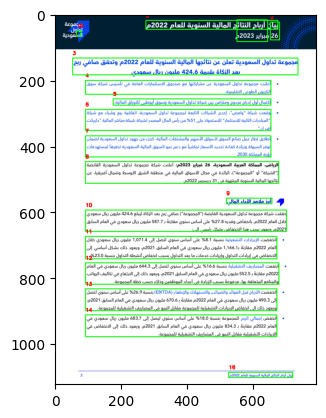

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Load the image
img = cv2.imread('original_images/2.png')

# Loop over the bounding boxes
for box in order_predictions[0].bboxes:
    # Extract the bounding box coordinates
    x1, y1, x2, y2 = box.bbox
    position = box.position

    # Draw the bounding box
    cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

    # Write the position on the image
    cv2.putText(img, str(position), (int(x1), int(y1 - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

# Save the output image
cv2.imwrite('output.jpg', img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

### Store relevant text areas

In [10]:
paths = sorted([f'original_images/{path}' for path in os.listdir('original_images')])
images = [cv2.imread(path) for path in paths]
output_dir = 'cropped_images'
table_locations = []
figure_locations = []

if not os.path.exists(output_dir):
		os.makedirs(output_dir)

def crop_and_save(image, bbox, label, page_num, bbox_num):
		x1, y1, x2, y2 = bbox
		if y2-y1 > 10 and x2-x1 > 10:
			cropped_image = image[y1:y2, x1:x2]
			filename = f"{page_num}-{bbox_num}_{label}.png"
			cv2.imwrite(os.path.join(output_dir, filename), cropped_image)

for page_num, page in enumerate(layout_predictions):
	for bbox_num, bbox in enumerate(page.bboxes):
		label = bbox.label
		if label in ['Text', 'Title', 'Section-header']:
			crop_and_save(images[page_num], bbox.bbox, label, page_num+2, bbox_num)
		elif label == 'Table':
			table_locations.append(page_num+2)
			crop_and_save(images[page_num], bbox.bbox, label, page_num+2, bbox_num)
		elif label == 'Figure':
			figure_locations.append(page_num+2)
			crop_and_save(images[page_num], bbox.bbox, label, page_num+2, bbox_num)

table_locations = set(table_locations)
figure_locations = set(figure_locations)
print(f'Tables located in page numbers: {table_locations}')
print(f'Figures located in page numbers: {figure_locations}')

Tables located in page numbers: {5}
Figures located in page numbers: {2, 3, 4, 5, 6}


### Better OCR

#### Text

In [10]:
with open('extracted_text.txt', 'r+', encoding='utf-8') as file:
	lines = [line for line in file.readlines() if line.strip()]
	file.seek(0)
	file.writelines(lines)
	file.truncate()

In [8]:
paths = sorted([f'cropped_images/{path}' for path in os.listdir('cropped_images') if not path.endswith("_Table.png") and not path.endswith("_Figure.png")])

predictions = run_surya(paths)

Recognizing Text:   0%|          | 0/1 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/generation/utils.py:1518: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Recognizing Text: 100%|██████████| 1/1 [00:05<00:00,  5.06s/it]


In [9]:
with open('extracted_text.txt', 'w', encoding='utf-8') as f:
  for page in predictions:
    for text_line in page.text_lines:
      f.write(text_line.text + "\n")

#### Tables

##### Table #1

In [11]:
paths = sorted([f'cropped_images/{path}' for path in os.listdir('cropped_images') if path.endswith("_Table.png")])

predictions = run_surya(paths)

Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


Recognizing Text:   0%|          | 0/1 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/generation/utils.py:1518: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Recognizing Text: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


In [12]:
table_page_nums = ','.join(map(str, list(table_locations)))

In [13]:
table_text = ""
for text_line in predictions[0].text_lines:
	table_text += f"{text_line.text}\n"

In [14]:
table_page_nums

'5'

In [20]:
table_page_nums = ','.join(map(str, list(table_locations)))

tables = camelot.read_pdf('data/pdf1/Press Release - 2022 Results (Stock Market).pdf', flavor='stream', pages=table_page_nums)
df_1 = tables[0].df

p='\n'.join(table_text.split('\n')[8:])

column_vals = []
lines = p.split('\n')
for a in range(len(lines)):
  if not is_number(lines[a]) and len(lines[a]) > 1:
    column_vals.append(lines[a])

rows_offset = df_1.shape[0] - len(column_vals)

df_1.loc[rows_offset:, 4] = column_vals
df_1[3] = df_1[3] + df_1[4]
df_1=df_1.drop(columns=4)
df_1.columns = headers
df_filtered_1 = df_1.loc[3:]

df_filtered_1 = clean_text(df_filtered_1.copy(), slice=True)
df_filtered_1 = clean_text(df_filtered_1.copy())

df_filtered_1

,التفير %,العام المالي 2021,العام المالي 2022,مليون ريال سعودي
3,8.1%,"1,166.1","1,071.4",البيرادات التشغيلية
4,17.3%,495.5,581.1,المصاريف التشغيلية
5,26.9%,670.6,490.3,(EBITDA)ﺍﻟﻤﺮﺑﺎﺡ ﻗﺒﻞ ﺍﻟﻔﻮﺍﺋﺪ ﻭﺍﻟﻀﺮﺍﺋﺐ ﻭﺍﻟﺪﺳﺘﻬﻠﺪ...
6,,58%,46%,(EBITDA) ءﺎﻫﺎﻣﺶ ﻗﺒﻞ ﺍﻟﻔﻮﺍﺋﺪ ﻭﺍﻟﻀﺮﺍﺋﺐ ﻭﺍﻟﺪﺳﺘﻬﻠﺘ...
7,10.8%,57.0,63.2,ﻣﺼﺮﻭﻓﺎﺕ ﺍﻟﺪﺳﺘﻬﻠﻨﻚ ﻭﺍﻟﺒﻄﻔﺎﺀ
8,30.4%,613.6,427.1,(EBIT) النرياح قبل احتساب مصاريف الفوائد والزك...
9,,53%,40%,(EBIT) ﺐﺋاﻫﺎﻣﺶ ﺍﻟﻔﺮﻳﺎﺡ ﻗﺒﻞ ﺍﺣﺘﺴﺎﺏ ﻣﺼﺎﺭﻳﻒ ﺍﻟﻔﻮﺍ...
10,72.1%,43.6,75.1,إيرادات الدستثمارات وإيرادات اخرى
11,202.5%,(3.3),(9.9),الخسارة من الشركات الزميلة
12,2.2%,66.2,67.7,ﺍﻟﺰﻛﺎﺓ


##### Table #2

In [41]:
table_text = ""
for text_line in predictions[1].text_lines:
	table_text += f"{text_line.text}\n"

In [44]:
tables = camelot.read_pdf('data/pdf1/Press Release - 2022 Results (Stock Market).pdf', flavor='stream', pages=table_page_nums, table_areas=['69,414,588,210'])
df_2 = tables[0].df

p='\n'.join(table_text.split('\n')[5:])

column_vals = []
lines = p.split('\n')
for a in range(3, len(lines)):
  if not is_number(lines[a]) and len(lines[a]) > 1:
    column_vals.append(lines[a])

rows_offset = df_2.shape[0] - len(column_vals)

df_2.iloc[rows_offset:, 4] = column_vals
df_2[3] = df_2[3] + df_2[4]
df_2=df_2.drop(columns=4)
df_2.columns = headers
df_filtered_2 = df_2.iloc[4:]

df_filtered_2 = clean_text(df_filtered_2.copy(), slice=True)
df_filtered_2 = clean_text(df_filtered_2.copy())

df_filtered_2

,التفير %,العام المالي 2021,العام المالي 2022,مليون ريال سعودي
4,2358.1%,86.2,"2,118.8",النقد وما يعادله
5,74.9%,"2,687.0",674.4,الدستثمارات
6,▲ \n \n535.,770.1,"4,896.8",أصول أخرى
7,117.0%,"3,543.3","7,690.0",إجمالى الموجودات
8,900.3%,450.9,"4,510.4",إجمالى المطلوبات
9,2.8%,"3,092.4","3,179.7",إجمالى حقوق الملكية


In [ ]:
with open('data/pdf1/extracted_text.txt', 'a', encoding='utf-8') as f:
  for _, row in df_filtered_1.iterrows():
    f.write(f"اﻟﺮﺑﺢ و اﻟﺨﺴﺎرة {row['مليون ريال سعودي']}: 'العام المالي 2022 {row['العام المالي 2022']}, العام المالي 2021 {row['العام المالي 2021']}, التفير {row['التفير %']}. \n")

In [ ]:
with open('data/pdf1/extracted_text.txt', 'a', encoding='utf-8') as f:
  for _, row in df_filtered_2.iterrows():
    f.write(f"اﻟﻤﺮﻛﺰ اﻟﻤﺎﻟﻲ {row['مليون ريال سعودي']}: 'العام المالي 2022 {row['العام المالي 2022']}, العام المالي 2021 {row['العام المالي 2021']}, التفير {row['التفير %']}. \n")